In [2]:
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizers
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.sequence import pad_sequences

from utils.callbacks import EarlyStopping
from utils.dataset import Hazumi1902

In [3]:
np.random.seed(123) 
torch.manual_seed(123) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
'''
モデルの定義
'''

class BiRNN(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__() 
        self.l1 = nn.LSTM(1463, hidden_dim, batch_first=True, bidirectional=True)
        self.l2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.l3 = nn.Linear(hidden_dim*2, 2) 

        nn.init.xavier_normal_(self.l1.weight_ih_l0)
        nn.init.orthogonal_(self.l1.weight_hh_l0) 
        nn.init.xavier_normal_(self.l2.weight_ih_l0)
        nn.init.orthogonal_(self.l2.weight_hh_l0) 
        nn.init.xavier_normal_(self.l3.weight) 

    def forward(self, x):
        h, _ = self.l1(x) 
        h, _ = self.l2(h)
        h = self.l3(h) # 入力hでいいのか
        y = F.softmax(h, dim=2)
        return y.squeeze()

testfilename :  ../data/dumpfiles/1902F2001.csv


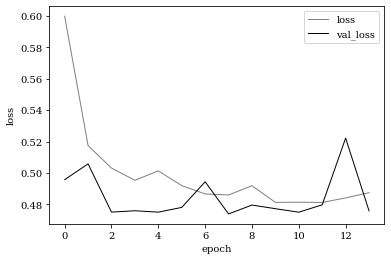

test_loss: 0.563, test_acc: 0.748
testfilename :  ../data/dumpfiles/1902F2002.csv


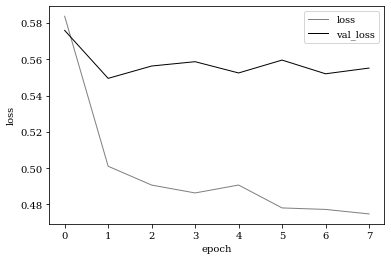

test_loss: 0.526, test_acc: 0.788
testfilename :  ../data/dumpfiles/1902F3001.csv


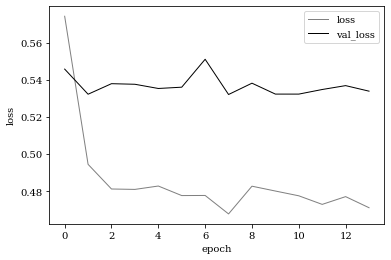

test_loss: 0.567, test_acc: 0.767
testfilename :  ../data/dumpfiles/1902F3002.csv


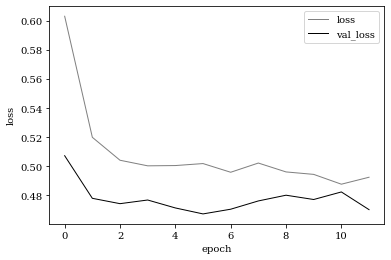

test_loss: 0.507, test_acc: 0.817
testfilename :  ../data/dumpfiles/1902F4001.csv


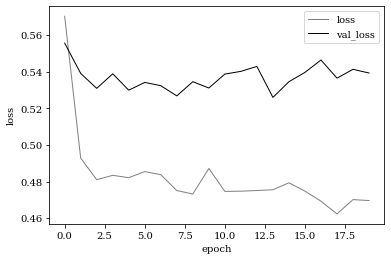

test_loss: 0.555, test_acc: 0.750
testfilename :  ../data/dumpfiles/1902F4002.csv


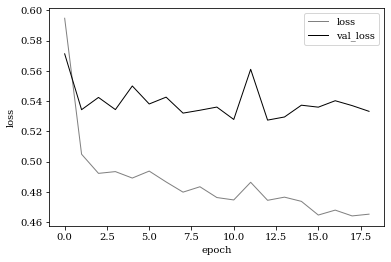

test_loss: 0.487, test_acc: 0.809
testfilename :  ../data/dumpfiles/1902F4003.csv


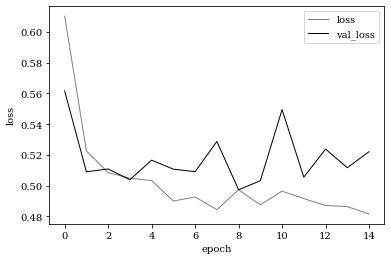

test_loss: 0.562, test_acc: 0.737
testfilename :  ../data/dumpfiles/1902F4004.csv


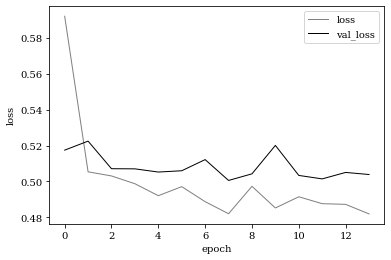

test_loss: 0.613, test_acc: 0.693
testfilename :  ../data/dumpfiles/1902F4005.csv


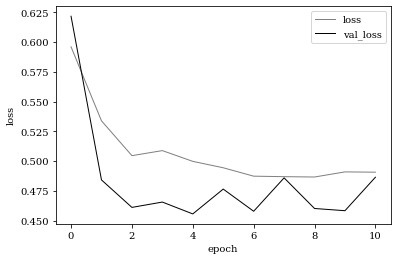

test_loss: 0.551, test_acc: 0.767
testfilename :  ../data/dumpfiles/1902F4006.csv


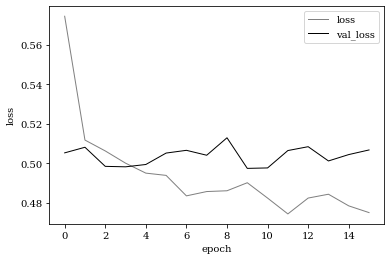

test_loss: 0.604, test_acc: 0.687
testfilename :  ../data/dumpfiles/1902F4008.csv


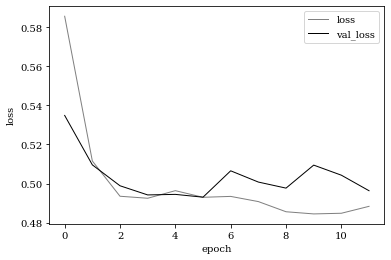

test_loss: 0.636, test_acc: 0.663
testfilename :  ../data/dumpfiles/1902F4009.csv


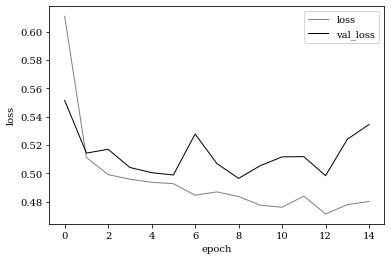

test_loss: 0.594, test_acc: 0.717
testfilename :  ../data/dumpfiles/1902F4010.csv


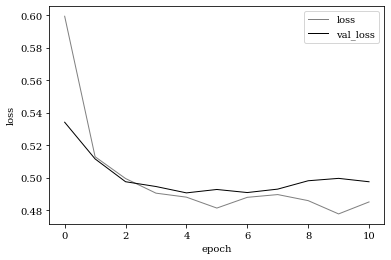

test_loss: 0.576, test_acc: 0.724
testfilename :  ../data/dumpfiles/1902F4011.csv


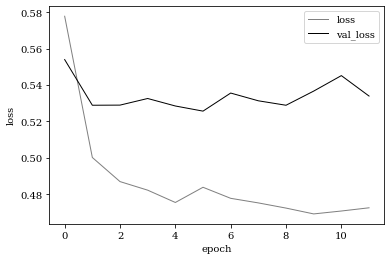

test_loss: 0.615, test_acc: 0.701
testfilename :  ../data/dumpfiles/1902F6001.csv


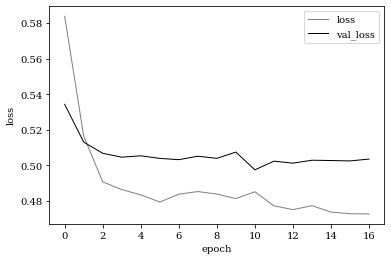

test_loss: 0.570, test_acc: 0.733
testfilename :  ../data/dumpfiles/1902F6002.csv


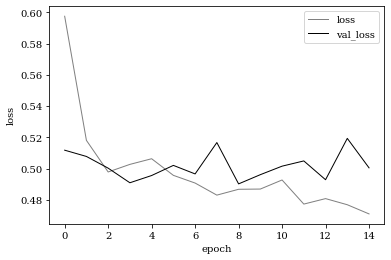

test_loss: 0.493, test_acc: 0.825
testfilename :  ../data/dumpfiles/1902F7001.csv


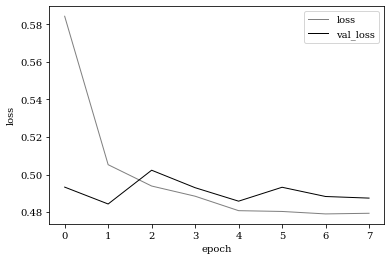

test_loss: 0.801, test_acc: 0.487
testfilename :  ../data/dumpfiles/1902F7002.csv


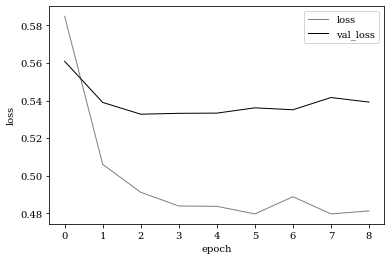

test_loss: 0.561, test_acc: 0.741
testfilename :  ../data/dumpfiles/1902F7003.csv


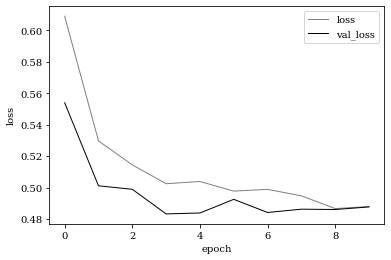

test_loss: 0.454, test_acc: 0.857
testfilename :  ../data/dumpfiles/1902M2001.csv


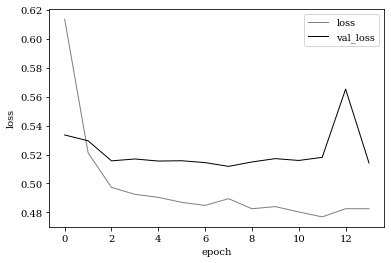

test_loss: 0.480, test_acc: 0.831
testfilename :  ../data/dumpfiles/1902M3001.csv


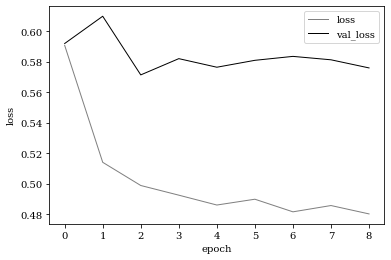

test_loss: 0.448, test_acc: 0.878
testfilename :  ../data/dumpfiles/1902M4001.csv


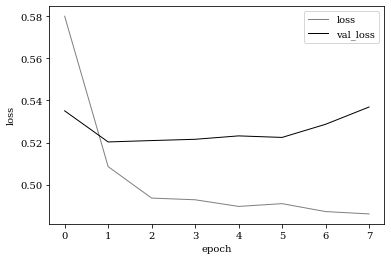

test_loss: 0.481, test_acc: 0.841
testfilename :  ../data/dumpfiles/1902M4002.csv


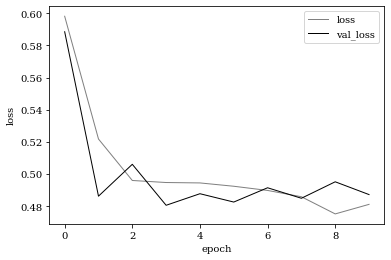

test_loss: 0.615, test_acc: 0.697
testfilename :  ../data/dumpfiles/1902M5001.csv


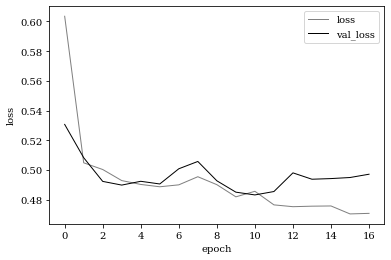

test_loss: 0.650, test_acc: 0.639
testfilename :  ../data/dumpfiles/1902M5002.csv


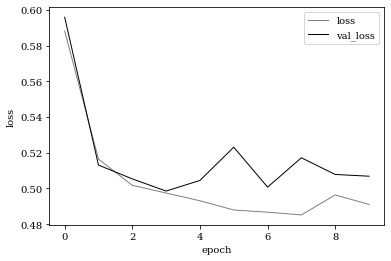

test_loss: 0.536, test_acc: 0.778
testfilename :  ../data/dumpfiles/1902M5003.csv


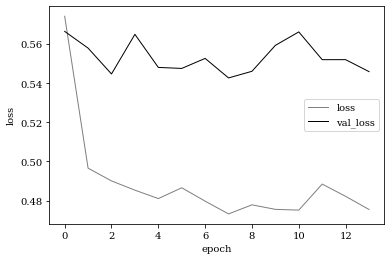

test_loss: 0.517, test_acc: 0.802
testfilename :  ../data/dumpfiles/1902M7001.csv


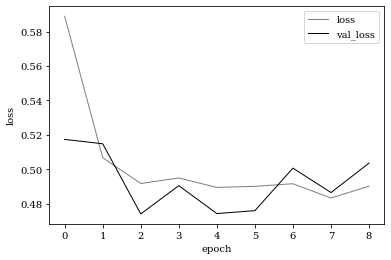

test_loss: 0.763, test_acc: 0.534
testfilename :  ../data/dumpfiles/1902M7002.csv


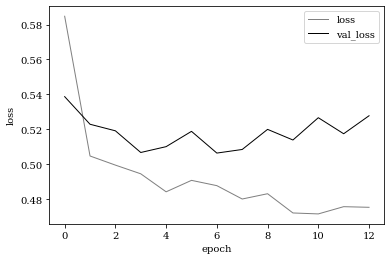

test_loss: 0.599, test_acc: 0.679
0.7368421052631579


In [13]:
'''
データの準備
'''

#target {1: emotion, 2: personality traits}
hazumi = Hazumi1902(target=1)

test_preds = [] 
test_ans = []
test_accs = {}

for testfile in hazumi.files:

    print('testfilename : ', testfile)

    x_train, x_test, t_train, t_test = hazumi.load_data(testfile=testfile)
    x_train, x_val, t_train, t_val = train_test_split(x_train, t_train, test_size=0.2)

    #標準化
    # maxlen = 50
    x_train = pad_sequences(x_train,padding='post')
    x_val = pad_sequences(x_val,padding='post')
    x_test = pad_sequences(x_test,padding='post')

    t_train = pad_sequences(t_train, padding='post')
    t_val = pad_sequences(t_val, padding='post')
    t_test = pad_sequences(t_test, padding='post')


    ''' 
    モデルの学習
    '''
    model = BiRNN(200).to(device)
    criterion = nn.CrossEntropyLoss() #CrossEntropyLoss()?
    optimizer = optimizers.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), amsgrad=True)

    def compute_loss(t, y):
        return criterion(y, t)

    def train_step(x, t):
        x = torch.Tensor(x).to(device) 
        t = torch.LongTensor(t).to(device) 
        model.train() 
        preds = model(x) 
        loss = compute_loss(t.reshape(-1), preds.reshape(-1, 2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss, preds 

    def val_step(x, t):
        x = torch.Tensor(x).to(device) 
        t = torch.LongTensor(t).to(device)
        model.eval() 
        preds = model(x) 
        loss = criterion(preds.reshape(-1, 2), t.reshape(-1))

        return loss, preds

    epochs = 1000 
    batch_size = 2
    n_batches_train = x_train.shape[0] // batch_size 
    n_batches_val = x_val.shape[0] // batch_size
    es = EarlyStopping(patience=5, verbose=1) 

    hist = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        train_loss = 0. 
        train_acc = 0. 
        val_loss = 0. 
        val_acc = 0. 
        x_, t_ = shuffle(x_train, t_train) 


        for batch in range(n_batches_train):
            start = batch * batch_size 
            end = start + batch_size
            loss, preds = train_step(x_[start:end], t_[start:end]) 
            train_loss += loss.item()
            train_acc += accuracy_score(t_[start:end].reshape(-1).tolist(), preds.argmax(dim=-1).reshape(-1).tolist())

        train_loss /= n_batches_train 
        train_acc /= n_batches_train 

        for batch in range(n_batches_val):
            start = batch * batch_size 
            end =start + batch_size
            loss, preds = val_step(x_val[start:end], t_val[start:end]) 
            val_loss += loss.item() 
            val_acc += accuracy_score(t_val[start:end].reshape(-1).tolist(), preds.argmax(dim=-1).reshape(-1).tolist())

        val_loss /= n_batches_val
        val_acc /= n_batches_val 

        hist['loss'].append(train_loss) 
        hist['accuracy'].append(train_acc) 
        hist['val_loss'].append(val_loss) 
        hist['val_accuracy'].append(val_acc) 


        if es(val_loss):
            break
        
    '''
    モデルの評価
    ''' 

    loss = hist['loss'] 
    val_loss = hist['val_loss'] 

    fig = plt.figure() 
    plt.rc('font', family='serif') 
    plt.plot(range(len(loss)), loss, color='gray', linewidth=1, label='loss') 
    plt.plot(range(len(val_loss)), val_loss, color='black', linewidth=1, label='val_loss') 
    plt.xlabel('epoch') 
    plt.ylabel('loss') 
    plt.legend() 
    plt.show() 


    def test_step(x, t):
        return val_step(x, t) 

    loss, preds = test_step(x_test, t_test) 
    test_loss = loss.item() 
    test_acc = accuracy_score(t_test[0].reshape(-1).tolist(), preds.argmax(dim=-1).reshape(-1).tolist()) 

    print('test_loss: {:.3f}, test_acc: {:.3f}'.format(test_loss, test_acc))

    test_ans.extend(t_test.reshape(-1).tolist())
    test_preds.extend(preds.argmax(dim=-1).reshape(-1).tolist())
    test_accs[testfile] = accuracy_score(t_test[0].reshape(-1).tolist(), preds.argmax(dim=-1).reshape(-1).tolist())

print(accuracy_score(test_ans, test_preds))


In [6]:
print(classification_report(test_ans, test_preds)) 

              precision    recall  f1-score   support

           0       0.65      0.48      0.56       816
           1       0.76      0.86      0.81      1521

    accuracy                           0.73      2337
   macro avg       0.71      0.67      0.68      2337
weighted avg       0.72      0.73      0.72      2337



In [14]:
test_accs

{'../data/dumpfiles/1902F2001.csv': 0.7477477477477478,
 '../data/dumpfiles/1902F2002.csv': 0.7878787878787878,
 '../data/dumpfiles/1902F3001.csv': 0.7666666666666667,
 '../data/dumpfiles/1902F3002.csv': 0.8170731707317073,
 '../data/dumpfiles/1902F4001.csv': 0.75,
 '../data/dumpfiles/1902F4002.csv': 0.8088235294117647,
 '../data/dumpfiles/1902F4003.csv': 0.7368421052631579,
 '../data/dumpfiles/1902F4004.csv': 0.6933333333333334,
 '../data/dumpfiles/1902F4005.csv': 0.7666666666666667,
 '../data/dumpfiles/1902F4006.csv': 0.6869565217391305,
 '../data/dumpfiles/1902F4008.csv': 0.6626506024096386,
 '../data/dumpfiles/1902F4009.csv': 0.7169811320754716,
 '../data/dumpfiles/1902F4010.csv': 0.7244897959183674,
 '../data/dumpfiles/1902F4011.csv': 0.7012987012987013,
 '../data/dumpfiles/1902F6001.csv': 0.7325581395348837,
 '../data/dumpfiles/1902F6002.csv': 0.825,
 '../data/dumpfiles/1902F7001.csv': 0.48717948717948717,
 '../data/dumpfiles/1902F7002.csv': 0.7411764705882353,
 '../data/dumpfile